###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# 2D Navier–Stokes: Channel Flow

In this notebook, we will use our very basic 2D Navier-Stokes solver to model the flow field in a channel, also known as Poiseuille flow.

## Channel Flow with Navier–Stokes

The only difference between the channel flow and cavity flow problem from the last notebook is that we are going to add a source term to the $u$-momentum equation, to mimic the effect of a pressure-driven channel flow. Here are our modified Navier–Stokes equations:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right)+F$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)$$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}=-\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
$$

### Discretized equations

With patience and care, we write the discretized form of the equations. It is highly recommended that you write these in your own hand, mentally following each term as you write it.

The $u$-momentum equation:

$$
\begin{split}
& \frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y} = \\
& \qquad -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x} \\
& \qquad +\nu\left(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2}\right)+F_{i,j}
\end{split}
$$

The $v$-momentum equation:

$$
\begin{split}
& \frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y} = \\
& \qquad -\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y} \\
& \qquad +\nu\left(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2}\right)
\end{split}
$$

And the pressure equation:

$$
\begin{split}
& \frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2} + \frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2} = \\
& \qquad \rho\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right) - \frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} - 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} - \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

As always, we need to re-arrange these equations to the form we need in the code to make the iterations proceed. 

For the $u$- and $v$ momentum equations, we isolate the velocity at time step `n+1`:

$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu\left[\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right] \\
& + \Delta t F
\end{split}
$$

$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(v_{i,j}^{n}-v_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(v_{i,j}^{n}-v_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu\left[\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right]
\end{split}
$$

And for the pressure equation, we isolate the term $p_{i,j}^n$ to iterate in pseudo-time:

$$
\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2(\Delta x^2+\Delta y^2)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t} \left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} + \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right) - \frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} - 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} - \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

The initial condition is $u, v, p=0$ everywhere, and at the boundary conditions are:

$u, v, p$ are periodic on $x=0,2$

$u, v =0$ at $y =0,2$

$\frac{\partial p}{\partial y}=0$ at $y =0,2$

$F=1$ everywhere.

Let's begin by importing our usual run of libraries:


In [2]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# import JIT from Numba
from numba import jit

In the previous notebook, we isolated a portion of our transposed equation to make it easier to parse and we're going to do the same thing here.  One thing to note is that we have periodic boundary conditions throughout this grid, so we need to explicitly calculate the values at the leading and trailing edge of our `u` vector.

In [3]:
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def build_up_b(rho, dt, dx, dy, u, v):
    
    b = numpy.zeros_like(u)
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            
            b[j, i] = (rho * (1 / dt * ((u[j, i+1] - u[j, i-1]) / (2 * dx) + 
                                        (v[j+1, i] - v[j-1, i]) / (2 * dy)) -
                              ((u[j, i+1] - u[j, i-1]) / (2 * dx))**2 -
                              2 * ((u[j+1, i] - u[j-1, i]) / (2 * dy) *
                                   (v[j, i+1] - v[j, i-1]) / (2 * dx))-
                                  ((v[j+1, i] - v[j-1, i]) / (2 * dy))**2))
    
    # Apply periodic boundary conditions
    for j in range(1,ny-1):
        
            # Periodic BC Pressure @ x = 2
            i = -1
            b[j, i] = (rho * (1 / dt * ((u[j, 0] - u[j, i-1]) / (2 * dx) + 
                                        (v[j+1, i] - v[j-1, i]) / (2 * dy)) -
                              ((u[j, 0] - u[j, i-1]) / (2 * dx))**2 -
                              2 * ((u[j+1, i] - u[j-1, i]) / (2 * dy) *
                                   (v[j, 0] - v[j, i-1]) / (2 * dx))-
                                  ((v[j+1, i] - v[j-1, i]) / (2 * dy))**2))            

            # Periodic BC Pressure @ x = 0
            i = 0
            b[j, i] = (rho * (1 / dt * ((u[j, i+1] - u[j, -1]) / (2 * dx) + 
                                        (v[j+1, i] - v[j-1, i]) / (2 * dy)) -
                              ((u[j, i+1] - u[j, -1]) / (2 * dx))**2 -
                              2 * ((u[j+1, i] - u[j-1, i]) / (2 * dy) *
                                   (v[j, i+1] - v[j, -1]) / (2 * dx))-
                                  ((v[j+1, i] - v[j-1, i]) / (2 * dy))**2))
    
    return b

We'll also define a Pressure Poisson iterative function.  Once more, note that we have to include the periodic boundary conditions at the leading and trailing edge.  We also have to specify Neumann boundary conditions at the top and bottom of our grid.

In [4]:
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def pressure_poisson_periodic(p, dx, dy):
    
    pn = numpy.empty_like(p)
    
    for q in range(nit):

        pn = p.copy()
        
        # loop over spatial grid 
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                                                
                p[j, i] = (((pn[j, i+1] + pn[j, i-1]) * dy**2 + 
                            (pn[j+1, i] + pn[j-1, i]) * dx**2) /
                            (2 * (dx**2 + dy**2)) -
                            dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                            b[j,i])
                
        # Apply periodic boundary conditions
        for j in range(1,ny-1):
        
            # Periodic BC Pressure @ x = 2
            i = -1
            p[j, i] = (((pn[j, 0] + pn[j, i-1]) * dy**2 + 
                                (pn[j+1, i] + pn[j-1, i]) * dx**2) /
                                (2 * (dx**2 + dy**2)) -
                                dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                b[j,i])
            
            # Periodic BC Pressure @ x = 0
            i = 0
            p[j, i] = (((pn[j, i+1] + pn[j, -1]) * dy**2 + 
                                (pn[j+1, i] + pn[j-1, i]) * dx**2) /
                                (2 * (dx**2 + dy**2)) -
                                dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                b[j,i])
        
        # Wall boundary conditions, pressure
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    
    return p

Now we have our familiar list of variables and initial conditions to declare before we start.

In [5]:
# variable declarations
nx = 41
ny = 41
nt = 10
nit = 50 
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)


# physical variables
rho = 1
nu = .1
F = 1
dt = .01

# initial conditions
u = numpy.zeros((ny, nx))
un = numpy.zeros((ny, nx))

v = numpy.zeros((ny, nx))
vn = numpy.zeros((ny, nx))

p = numpy.ones((ny, nx))
pn = numpy.ones((ny, nx))

b = numpy.zeros((ny, nx))

For the meat of our computation, we're going to reach back to a trick we used to [solve Laplace's Equation](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/07_BVP_2D/01_2D_Laplace_Equation.ipynb).  We're interested in what our grid will look like once we've reached a near-steady state.  We can either specify a number of timesteps `nt` and increment it until we're satisfied with the results, or we can tell our code to run until the difference between two consecutive iterations is very small.  

We also have to manage **8** separate boundary conditions for each iteration.  The code below writes each of them out explicitly.  If you're interested in a challenge, you can try to write a function which can handle some or all of these boundary conditions.  If you're interested in tackling that, you should probably read up on Python [dictionaries](http://docs.python.org/2/tutorial/datastructures.html#dictionaries).  

In [6]:
udiff = 1
stepcount = 0

while udiff > .001:
    
    un = u.copy()
    vn = v.copy()

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)

    # update velocity components
    for i in range(1,nx-1):
            for j in range(1,ny-1):
                
                u[j, i] = (un[j, i]-
                                 un[j, i] * dt / dx *
                                (un[j, i] - un[j, i-1]) -
                                 vn[j, i] * dt / dy *
                                (un[j, i] - un[j-1, i]) -
                                 dt / (2 * rho * dx) * (p[j, i+1] - p[j, i-1]) +
                                 nu * (dt / dx**2 *
                                (un[j, i+1] - 2 * un[j, i] + un[j, i-1]) +
                                 dt / dy**2 *
                                (un[j+1, i] - 2 * un[j, i] + un[j-1, i])) + 
                                 F * dt)

                v[j, i] = (vn[j, i] -
                                un[j, i] * dt / dx *
                               (vn[j, i] - vn[j, i-1]) -
                                vn[j, i] * dt / dy *
                               (vn[j, i] - vn[j-1, i]) -
                                dt / (2 * rho * dy) * (p[j+1, i] - p[j-1, i]) +
                                nu * (dt / dx**2 *
                               (vn[j, i+1] - 2 * vn[j, i] + vn[j, i-1]) +
                                dt / dy**2 *
                               (vn[j+1, i] - 2 * vn[j, i] + vn[j-1, i])))

    # Periodic BC u, v @ x = 2
    for j in range(1,ny-1):

        i = -1
        u[j, i] = (un[j, i] - un[j, i] * dt / dx * 
                      (un[j, i] - un[j, i-1]) -
                       vn[j, i] * dt / dy * 
                      (un[j, i] - un[j-1, i]) -
                       dt / (2 * rho * dx) *
                      (p[j, 0] - p[j, i]) + 
                       nu * (dt / dx**2 * 
                      (un[j, 0] - 2 * un[j,i] + un[j, i-1]) +
                       dt / dy**2 * 
                      (un[j+1, i] - 2 * un[j, i] + un[j-1, i])) + F * dt)

        v[j, i] = (vn[j, i] - un[j, i] * dt / dx *
                      (vn[j, i] - vn[j, i-1]) -
                       vn[j, i] * dt / dy *
                      (vn[j, i] - vn[j-1, i]) -
                       dt / (2 * rho * dy) * 
                      (p[j+1, i] - p[j-1, i]) +
                       nu * (dt / dx**2 *
                      (vn[j, 0] - 2 * vn[j, i] + vn[j, i-1]) +
                       dt / dy**2 *
                      (vn[j+1, i] - 2 * vn[j, i] + vn[j-1, i])))
        
    # Periodic BC u, v @ x = 0
    for j in range(1,ny-1):
        
        i = 0
        u[j, i] = (un[j, i] - un[j, i] * dt / dx *
                  (un[j, i] - un[j, -1]) -
                   vn[j, i] * dt / dy *
                  (un[j, i] - un[j-1, i]) -
                   dt / (2 * rho * dx) * (p[j, i+1] - p[j, -1]) +
                   nu * (dt / dx**2 *
                  (un[j, i+1] - 2 * un[j, i] + un[j, -1]) +
                   dt / dy**2 *
                  (un[j+1, i] - 2 * un[j, i] + un[j-1, i])) + F * dt)

        v[j, i] = (vn[j, i] - un[j, i] * dt / dx *
                  (vn[j, i] - vn[j, -1]) -
                   vn[j, i] * dt / dy *
                  (vn[j, i] - vn[j-1, i]) -
                   dt / (2 * rho * dy) * (p[j+1, i] - p[j-1, i]) +
                   nu * (dt / dx**2 *
                  (vn[j, i+1] - 2 * vn[j, i] + vn[j, -1]) +
                   dt / dy**2 *
                  (vn[j+1, i] - 2 * vn[j, i] + vn[j-1, i])))        

    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :]=0
    
    udiff = (numpy.sum(u) - numpy.sum(un)) / numpy.sum(u)
    stepcount += 1

You can see that we've also included a variable `stepcount` to see how many iterations our loop went through before our stop condition was met.  

In [7]:
print(stepcount)

499


If you want to see how the number of iterations increases as our `udiff` condition gets smaller and smaller, try defining a function to perform the `while` loop written above that takes an input `udiff` and outputs the number of iterations that the function runs.  

For now, let's look at our results.  We've used the quiver function to look at the cavity flow results and it works well for channel flow, too.  

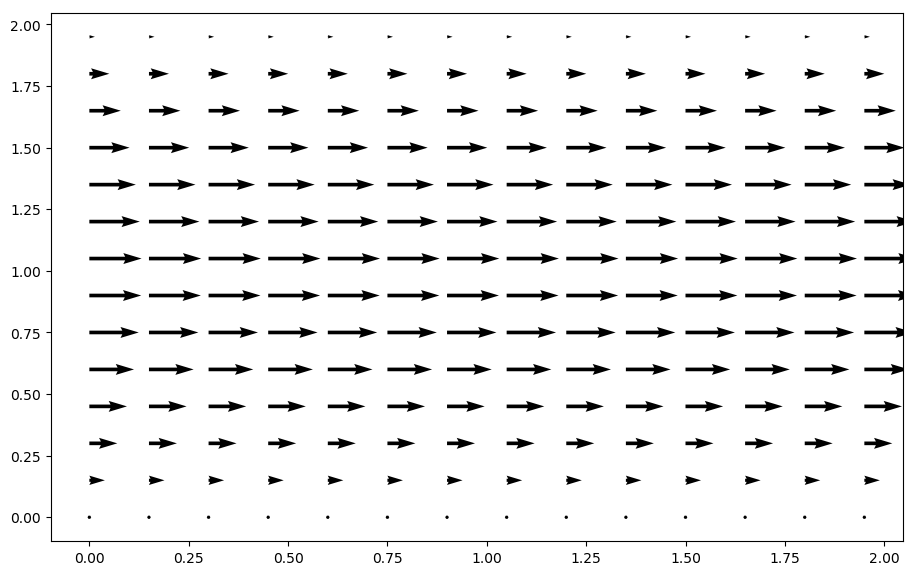

In [8]:
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);

The structures in the `quiver` command that look like `[::3, ::3]` are useful when dealing with large amounts of data that you want to visualize.  The one used above tells `matplotlib` to only plot every 3rd data point.  If we leave it out, you can see that the results can appear a little crowded.  

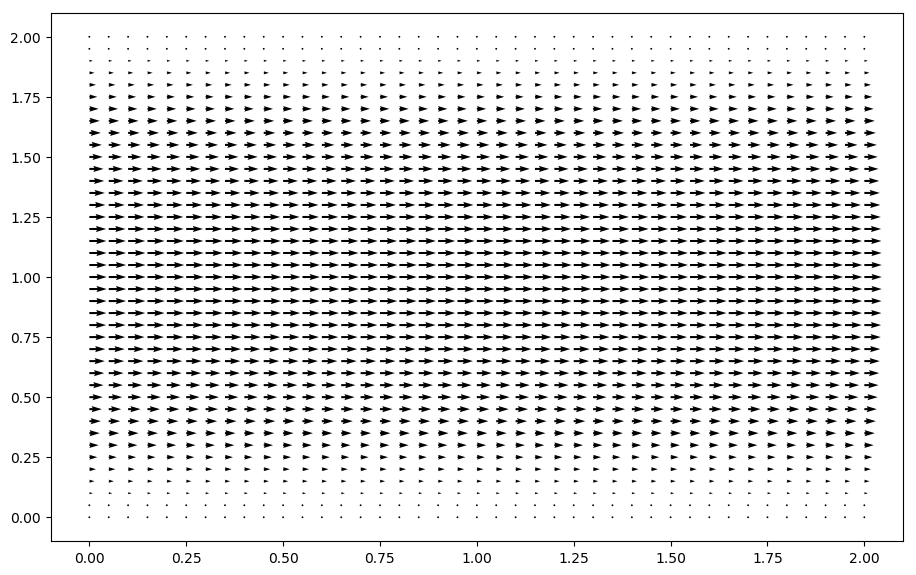

In [9]:
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X, Y, u, v);

## Learn more
***

##### What is the meaning of the $F$ term?

This notebook is an exercise demonstrating the problem of flow in a channel or pipe. If you recall from your fluid mechanics class, a specified pressure gradient is what drives Poisseulle flow. 

Recall the $x$-momentum equation:

$$\frac{\partial u}{\partial t}+u \cdot \nabla u = -\frac{\partial p}{\partial x}+\nu \nabla^2 u$$

What we actually do is split the pressure into steady and unsteady components $p=P+p'$. The applied steady pressure gradient is the constant $-\frac{\partial P}{\partial x}=F$ (interpreted as a source term), and the unsteady component is $\frac{\partial p'}{\partial x}$. So the pressure that we solve for is actually $p'$, which for a steady flow is in fact equal to zero everywhere.

<b>Why did we do this?</b>

Note that we use periodic boundary conditions for this flow. For a flow with a constant pressure gradient, the value of pressure on the left edge of the domain must be different from the pressure at the right edge. So we cannot apply periodic boundary conditions on the pressure directly. It is easier to fix the gradient and then solve for the perturbations in pressure.

<b>Shouldn't we always expect a uniform/constant $p'$ then?</b>

That's true only in the case of steady laminar flows. At high Reynolds numbers, flows in channels can become turbulent, and we will see unsteady fluctuations in the pressure, which will result in non-zero values for $p'$. 

In step 12, note that the pressure field itself is not constant, but it's the pressure perturbation field that is. The pressure field varies linearly along the channel with slope equal to the pressure gradient. Also, for incompressible flows, the absolute value of the pressure is inconsequential.


##### And explore more CFD materials online

The interactive module [**12 steps to Navier–Stokes**](https://github.com/barbagroup/CFDPython) is one of several components of the [Computational Fluid Dynamics class taught by Prof. Lorena A. Barba](https://www.youtube.com/playlist?list=PL30F4C5ABCE62CB61) in Boston University between 2009 and 2013.

For a sample of what the other components of this class are, you can explore the **Resources** section of the Spring 2013 version of [the course's Piazza site](https://piazza.com/bu/spring2013/me702/resources).

***